In [1]:
# meta-data does not work yet in VScode
# https://github.com/microsoft/vscode-jupyter/issues/1121

{
    "tags": [
        "hide-cell"
    ]
}


### Install necessary libraries

try:
    import jax
except:
    # For cuda version, see https://github.com/google/jax#installation
    %pip install --upgrade "jax[cpu]" 
    import jax

try:
    import distrax
except:
    %pip install --upgrade  distrax
    import distrax

try:
    import jsl
except:
    %pip install git+https://github.com/probml/jsl
    import jsl

try:
    import rich
except:
    %pip install rich
    import rich




In [2]:
{
    "tags": [
        "hide-cell"
    ]
}


### Import standard libraries

import abc
from dataclasses import dataclass
import functools
import itertools

from typing import Any, Callable, NamedTuple, Optional, Union, Tuple

import matplotlib.pyplot as plt
import numpy as np


import jax
import jax.numpy as jnp
from jax import lax, vmap, jit, grad
from jax.scipy.special import logit
from jax.nn import softmax
from functools import partial
from jax.random import PRNGKey, split

import inspect
import inspect as py_inspect
import rich
from rich import inspect as r_inspect
from rich import print as r_print

def print_source(fname):
    r_print(py_inspect.getsource(fname))

```{math}

\newcommand\floor[1]{\lfloor#1\rfloor}

\newcommand{\real}{\mathbb{R}}

% Numbers
\newcommand{\vzero}{\boldsymbol{0}}
\newcommand{\vone}{\boldsymbol{1}}

% Greek https://www.latex-tutorial.com/symbols/greek-alphabet/
\newcommand{\valpha}{\boldsymbol{\alpha}}
\newcommand{\vbeta}{\boldsymbol{\beta}}
\newcommand{\vchi}{\boldsymbol{\chi}}
\newcommand{\vdelta}{\boldsymbol{\delta}}
\newcommand{\vDelta}{\boldsymbol{\Delta}}
\newcommand{\vepsilon}{\boldsymbol{\epsilon}}
\newcommand{\vzeta}{\boldsymbol{\zeta}}
\newcommand{\vXi}{\boldsymbol{\Xi}}
\newcommand{\vell}{\boldsymbol{\ell}}
\newcommand{\veta}{\boldsymbol{\eta}}
%\newcommand{\vEta}{\boldsymbol{\Eta}}
\newcommand{\vgamma}{\boldsymbol{\gamma}}
\newcommand{\vGamma}{\boldsymbol{\Gamma}}
\newcommand{\vmu}{\boldsymbol{\mu}}
\newcommand{\vmut}{\boldsymbol{\tilde{\mu}}}
\newcommand{\vnu}{\boldsymbol{\nu}}
\newcommand{\vkappa}{\boldsymbol{\kappa}}
\newcommand{\vlambda}{\boldsymbol{\lambda}}
\newcommand{\vLambda}{\boldsymbol{\Lambda}}
\newcommand{\vLambdaBar}{\overline{\vLambda}}
%\newcommand{\vnu}{\boldsymbol{\nu}}
\newcommand{\vomega}{\boldsymbol{\omega}}
\newcommand{\vOmega}{\boldsymbol{\Omega}}
\newcommand{\vphi}{\boldsymbol{\phi}}
\newcommand{\vvarphi}{\boldsymbol{\varphi}}
\newcommand{\vPhi}{\boldsymbol{\Phi}}
\newcommand{\vpi}{\boldsymbol{\pi}}
\newcommand{\vPi}{\boldsymbol{\Pi}}
\newcommand{\vpsi}{\boldsymbol{\psi}}
\newcommand{\vPsi}{\boldsymbol{\Psi}}
\newcommand{\vrho}{\boldsymbol{\rho}}
\newcommand{\vtheta}{\boldsymbol{\theta}}
\newcommand{\vthetat}{\boldsymbol{\tilde{\theta}}}
\newcommand{\vTheta}{\boldsymbol{\Theta}}
\newcommand{\vsigma}{\boldsymbol{\sigma}}
\newcommand{\vSigma}{\boldsymbol{\Sigma}}
\newcommand{\vSigmat}{\boldsymbol{\tilde{\Sigma}}}
\newcommand{\vsigmoid}{\vsigma}
\newcommand{\vtau}{\boldsymbol{\tau}}
\newcommand{\vxi}{\boldsymbol{\xi}}


% Lower Roman (Vectors)
\newcommand{\va}{\mathbf{a}}
\newcommand{\vb}{\mathbf{b}}
\newcommand{\vBt}{\mathbf{\tilde{B}}}
\newcommand{\vc}{\mathbf{c}}
\newcommand{\vct}{\mathbf{\tilde{c}}}
\newcommand{\vd}{\mathbf{d}}
\newcommand{\ve}{\mathbf{e}}
\newcommand{\vf}{\mathbf{f}}
\newcommand{\vg}{\mathbf{g}}
\newcommand{\vh}{\mathbf{h}}
%\newcommand{\myvh}{\mathbf{h}}
\newcommand{\vi}{\mathbf{i}}
\newcommand{\vj}{\mathbf{j}}
\newcommand{\vk}{\mathbf{k}}
\newcommand{\vl}{\mathbf{l}}
\newcommand{\vm}{\mathbf{m}}
\newcommand{\vn}{\mathbf{n}}
\newcommand{\vo}{\mathbf{o}}
\newcommand{\vp}{\mathbf{p}}
\newcommand{\vq}{\mathbf{q}}
\newcommand{\vr}{\mathbf{r}}
\newcommand{\vs}{\mathbf{s}}
\newcommand{\vt}{\mathbf{t}}
\newcommand{\vu}{\mathbf{u}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\vw}{\mathbf{w}}
\newcommand{\vws}{\vw_s}
\newcommand{\vwt}{\mathbf{\tilde{w}}}
\newcommand{\vWt}{\mathbf{\tilde{W}}}
\newcommand{\vwh}{\hat{\vw}}
\newcommand{\vx}{\mathbf{x}}
%\newcommand{\vx}{\mathbf{x}}
\newcommand{\vxt}{\mathbf{\tilde{x}}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vyt}{\mathbf{\tilde{y}}}
\newcommand{\vz}{\mathbf{z}}
%\newcommand{\vzt}{\mathbf{\tilde{z}}}


% Upper Roman (Matrices)
\newcommand{\vA}{\mathbf{A}}
\newcommand{\vB}{\mathbf{B}}
\newcommand{\vC}{\mathbf{C}}
\newcommand{\vD}{\mathbf{D}}
\newcommand{\vE}{\mathbf{E}}
\newcommand{\vF}{\mathbf{F}}
\newcommand{\vG}{\mathbf{G}}
\newcommand{\vH}{\mathbf{H}}
\newcommand{\vI}{\mathbf{I}}
\newcommand{\vJ}{\mathbf{J}}
\newcommand{\vK}{\mathbf{K}}
\newcommand{\vL}{\mathbf{L}}
\newcommand{\vM}{\mathbf{M}}
\newcommand{\vMt}{\mathbf{\tilde{M}}}
\newcommand{\vN}{\mathbf{N}}
\newcommand{\vO}{\mathbf{O}}
\newcommand{\vP}{\mathbf{P}}
\newcommand{\vQ}{\mathbf{Q}}
\newcommand{\vR}{\mathbf{R}}
\newcommand{\vS}{\mathbf{S}}
\newcommand{\vT}{\mathbf{T}}
\newcommand{\vU}{\mathbf{U}}
\newcommand{\vV}{\mathbf{V}}
\newcommand{\vW}{\mathbf{W}}
\newcommand{\vX}{\mathbf{X}}
%\newcommand{\vXs}{\vX_{\vs}}
\newcommand{\vXs}{\vX_{s}}
\newcommand{\vXt}{\mathbf{\tilde{X}}}
\newcommand{\vY}{\mathbf{Y}}
\newcommand{\vZ}{\mathbf{Z}}
\newcommand{\vZt}{\mathbf{\tilde{Z}}}
\newcommand{\vzt}{\mathbf{\tilde{z}}}


%%%%
\newcommand{\hidden}{\vz}
\newcommand{\hid}{\hidden}
\newcommand{\observed}{\vy}
\newcommand{\obs}{\observed}
\newcommand{\inputs}{\vu}
\newcommand{\input}{\inputs}

\newcommand{\hmmTrans}{\vA}
\newcommand{\hmmObs}{\vB}
\newcommand{\hmmInit}{\vpi}
\newcommand{\hmmhid}{\hidden}
\newcommand{\hmmobs}{\obs}

\newcommand{\ldsDyn}{\vA}
\newcommand{\ldsObs}{\vC}
\newcommand{\ldsDynIn}{\vB}
\newcommand{\ldsObsIn}{\vD}
\newcommand{\ldsDynNoise}{\vQ}
\newcommand{\ldsObsNoise}{\vR}

\newcommand{\ssmDynFn}{f}
\newcommand{\ssmObsFn}{h}


%%%
\newcommand{\gauss}{\mathcal{N}}

\newcommand{\diag}{\mathrm{diag}}
```


(sec:hmm-intro)=
# Hidden Markov Models

In this section, we discuss the
hidden Markov model or HMM,
which is a state space model in which the hidden states
are discrete, so $\hmmhid_t \in \{1,\ldots, K\}$.
The observations may be discrete,
$\hmmobs_t \in \{1,\ldots, C\}$,
or continuous,
$\hmmobs_t \in \real^D$,
or some combination,
as we illustrate below.
More details can be found in e.g., 
{cite}`Rabiner89,Fraser08,Cappe05`.
For an interactive introduction,
see https://nipunbatra.github.io/hmm/.

(sec:casino)=
### Example: Casino HMM

To illustrate HMMs with categorical observation model,
we consider the "Ocassionally dishonest casino" model from {cite}`Durbin98`.
There are 2 hidden states, representing whether the dice being used in the casino is fair or loaded.
Each state defines a distribution over the 6 possible observations.

The transition model is denoted by
```{math}
p(z_t=j|z_{t-1}=i) = \hmmTrans_{ij}
```
Here the $i$'th row of $\vA$ corresponds to the outgoing distribution from state $i$.
This is  a row stochastic matrix,
meaning each row sums to one.
We can visualize
the non-zero entries in the transition matrix by creating a state transition diagram,
as shown in 
{numref}`fig:casino`.

```{figure} /figures/casino.png
:scale: 50%
:name: fig:casino

Illustration of the casino HMM.
```

The  observation model
$p(\obs_t|\hidden_t=j)$ has the form
```{math}
p(\obs_t=k|\hidden_t=j) = \hmmObs_{jk} 
```
This is represented by the histograms associated with each
state in  {numref}`casino-fig`.

Finally,
the initial state distribution is denoted by
```{math}
p(z_1=j) = \hmmInit_j
```

Collectively we denote all the parameters by $\vtheta=(\hmmTrans, \hmmObs, \hmmInit)$.

Now let us implement this model in code.

In [3]:
# state transition matrix
A = np.array([
    [0.95, 0.05],
    [0.10, 0.90]
])

# observation matrix
B = np.array([
    [1/6, 1/6, 1/6, 1/6, 1/6, 1/6], # fair die
    [1/10, 1/10, 1/10, 1/10, 1/10, 5/10] # loaded die
])

pi = np.array([0.5, 0.5])

(nstates, nobs) = np.shape(B)


In [4]:
import distrax
from distrax import HMM


hmm = HMM(trans_dist=distrax.Categorical(probs=A),
            init_dist=distrax.Categorical(probs=pi),
            obs_dist=distrax.Categorical(probs=B))

print(hmm)


Let's sample from the model. We will generate a sequence of latent states, $\hid_{1:T}$,
which we then convert to a sequence of observations, $\obs_{1:T}$.

In [5]:



seed = 314
n_samples = 300
z_hist, x_hist = hmm.sample(seed=PRNGKey(seed), seq_len=n_samples)

z_hist_str = "".join((np.array(z_hist) + 1).astype(str))[:60]
x_hist_str = "".join((np.array(x_hist) + 1).astype(str))[:60]

print("Printing sample observed/latent...")
print(f"x: {x_hist_str}")
print(f"z: {z_hist_str}")

Printing sample observed/latent...
x: 633665342652353616444236412331351246651613325161656366246242
z: 222222211111111111111111111111111111111222111111112222211111


Below is the source code for the sampling algorithm.



In [6]:
print_source(hmm.sample)

Let us check correctness by computing empirical pairwise statistics

We will compute the number of i->j latent state transitions, and check that it is close to the true 
A[i,j] transition probabilites.

In [7]:


import collections
def compute_counts(state_seq, nstates):
    wseq = np.array(state_seq)
    word_pairs = [pair for pair in zip(wseq[:-1], wseq[1:])]
    counter_pairs = collections.Counter(word_pairs)
    counts = np.zeros((nstates, nstates))
    for (k,v) in counter_pairs.items():
        counts[k[0], k[1]] = v
    return counts


def normalize(u, axis=0, eps=1e-15):
    u = jnp.where(u == 0, 0, jnp.where(u < eps, eps, u))
    c = u.sum(axis=axis)
    c = jnp.where(c == 0, 1, c)
    return u / c, c

def normalize_counts(counts):
    ncounts = vmap(lambda v: normalize(v)[0], in_axes=0)(counts)
    return ncounts

init_dist = jnp.array([1.0, 0.0])
trans_mat = jnp.array([[0.7, 0.3], [0.5, 0.5]])
obs_mat = jnp.eye(2)

hmm = HMM(trans_dist=distrax.Categorical(probs=trans_mat),
            init_dist=distrax.Categorical(probs=init_dist),
            obs_dist=distrax.Categorical(probs=obs_mat))

rng_key = jax.random.PRNGKey(0)
seq_len = 500
state_seq, _ = hmm.sample(seed=PRNGKey(seed), seq_len=seq_len)

counts = compute_counts(state_seq, nstates=2)
print(counts)

trans_mat_empirical = normalize_counts(counts)
print(trans_mat_empirical)

assert jnp.allclose(trans_mat, trans_mat_empirical, atol=1e-1)

[[225.  92.]
 [ 92.  90.]]
[[0.7097792  0.29022083]
 [0.50549453 0.4945055 ]]


Our primary goal will be to infer the latent state from the observations,
so we can detect if the casino is being dishonest or not. This will
affect how we choose to gamble our money.
We discuss various ways to perform this inference below.

(sec:lillypad)=
## Example: Lillypad HMM


If $\obs_t$ is continuous, it is common to use a Gaussian
observation model:
```{math}
p(\obs_t|\hidden_t=j) = \gauss(\obs_t|\vmu_j,\vSigma_j)
```
This is sometimes called a Gaussian HMM.

As a simple example, suppose we have an HMM with 3 hidden states,
each of which generates a 2d Gaussian.
We can represent these Gaussian distributions are 2d ellipses,
as we show below.
We call these ``lilly pads'', because of their shape.
We can imagine a frog hopping from one lilly pad to another.
(This analogy is due to the late Sam Roweis.)
The frog will stay on a pad for a while (corresponding to remaining in the same
discrete state $\hidden_t$), and then jump to a new pad
(corresponding to a transition to a new state).
The data we see are just the 2d points (e.g., water droplets)
coming from near the pad that the frog is currently on.
Thus this model is like a Gaussian mixture model,
in that it generates clusters of observations,
except now there is temporal correlation between the data points.

Let us now illustrate this model in code.



In [8]:
# Let us create the model

initial_probs = jnp.array([0.3, 0.2, 0.5])

# transition matrix
A = jnp.array([
[0.3, 0.4, 0.3],
[0.1, 0.6, 0.3],
[0.2, 0.3, 0.5]
])

# Observation model
mu_collection = jnp.array([
[0.3, 0.3],
[0.8, 0.5],
[0.3, 0.8]
])

S1 = jnp.array([[1.1, 0], [0, 0.3]])
S2 = jnp.array([[0.3, -0.5], [-0.5, 1.3]])
S3 = jnp.array([[0.8, 0.4], [0.4, 0.5]])
cov_collection = jnp.array([S1, S2, S3]) / 60


import tensorflow_probability as tfp

if False:
    hmm = HMM(trans_dist=distrax.Categorical(probs=A),
            init_dist=distrax.Categorical(probs=initial_probs),
            obs_dist=distrax.MultivariateNormalFullCovariance(
                loc=mu_collection, covariance_matrix=cov_collection))
else:
    hmm = HMM(trans_dist=distrax.Categorical(probs=A),
              init_dist=distrax.Categorical(probs=initial_probs),
              obs_dist=distrax.as_distribution(
                  tfp.substrates.jax.distributions.MultivariateNormalFullCovariance(loc=mu_collection,
                                                                                    covariance_matrix=cov_collection)))

print(hmm)

In [9]:

n_samples, seed = 50, 10
samples_state, samples_obs = hmm.sample(seed=PRNGKey(seed), seq_len=n_samples)

print(samples_state.shape)
print(samples_obs.shape)

(50,)
(50, 2)


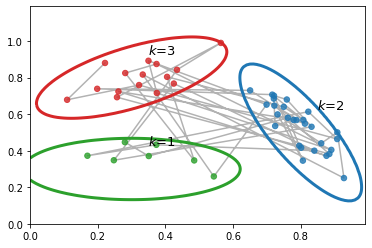

In [10]:

# Let's plot the observed data in 2d
xmin, xmax = 0, 1
ymin, ymax = 0, 1.2
colors = ["tab:green", "tab:blue", "tab:red"]

def plot_2dhmm(hmm, samples_obs, samples_state, colors, ax, xmin, xmax, ymin, ymax, step=1e-2):
    obs_dist = hmm.obs_dist
    color_sample = [colors[i] for i in samples_state]

    xs = jnp.arange(xmin, xmax, step)
    ys = jnp.arange(ymin, ymax, step)

    v_prob = vmap(lambda x, y: obs_dist.prob(jnp.array([x, y])), in_axes=(None, 0))
    z = vmap(v_prob, in_axes=(0, None))(xs, ys)

    grid = np.mgrid[xmin:xmax:step, ymin:ymax:step]

    for k, color in enumerate(colors):
        ax.contour(*grid, z[:, :, k], levels=[1], colors=color, linewidths=3)
        ax.text(*(obs_dist.mean()[k] + 0.13), f"$k$={k + 1}", fontsize=13, horizontalalignment="right")

    ax.plot(*samples_obs.T, c="black", alpha=0.3, zorder=1)
    ax.scatter(*samples_obs.T, c=color_sample, s=30, zorder=2, alpha=0.8)

    return ax, color_sample


fig, ax = plt.subplots()
_, color_sample = plot_2dhmm(hmm, samples_obs, samples_state, colors, ax, xmin, xmax, ymin, ymax)


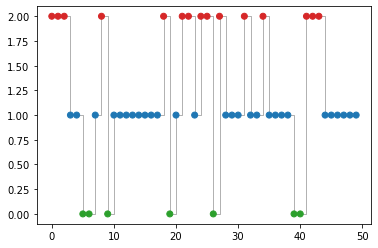

In [11]:
# Let's plot the hidden state sequence

fig, ax = plt.subplots()
ax.step(range(n_samples), samples_state, where="post", c="black", linewidth=1, alpha=0.3)
ax.scatter(range(n_samples), samples_state, c=color_sample, zorder=3)
